In [1]:
import numpy as np
import os
from DH_dynamics import dh_robot_config_dynamics
from JS_control import *
import matplotlib.pyplot as plt
from pyrep import PyRep
from arm import CtRobot
from pyrep.backend import vrep
import sympy as sp
from pyrep.const import JointMode
import time

%matplotlib notebook

pr = PyRep()

In [2]:
param = ['D', 'a', 'alpha', 'theta', 'num_joints', 'jointType', 'Tbase', 'L', 'M']
config = dict()
for i in range(len(param)):
    config[param[i]] = np.load('./robot_config/inbore/config/%s.npy'%param[i])

In [3]:
robot = dh_robot_config_dynamics(int(config['num_joints']), config['alpha'], config['theta'], config['D'], config['a'], 
                                                config['jointType'], config['Tbase'], config['L'], config['M'], 'robot_config/inbore')
robot.initKinematicTransforms()

Calculating link 0
Calculating link 1
Calculating link 2
Calculating link 3
Calculating link 4
Calculating Mass and Gravity Matrix...
Calculation complete


## Simulation Set up

### For all joints

In [4]:
pr.launch(os.getcwd() + '/in-bore.ttt', headless=False)
ct_robot = CtRobot(name='inbore_arm', num_joints=4, joint_type=['r','r','r','p'])

xyz = np.array([0, 0, 0])

In [6]:
dt = 0.01
pr.set_simulation_timestep(dt)

### Repeat the following 5 blocks until satisfactory gain parameters

In [51]:
# Gain
kp = np.diag([1.2, 0.25, 0.5, 0.5])
kv = np.diag([0.3, 0.088, 0.1, 0.00])


# Starting simulation
pr.start()
err_pos = []
err_vel = []
mespos = []
depos = []

# Set up joints to be in force control mode
for i in range(ct_robot._num_joints):
    ct_robot.joints[i].set_joint_mode(JointMode.FORCE)
    ct_robot.joints[i].set_control_loop_enabled(False)
    ct_robot.joints[i].set_motor_locked_at_zero_velocity(True)
    ct_robot.joints[i].set_joint_position(0)
# Set up arms to be in correct dynamic properties
# Disable the base arm and enable all other arms
for j in range(1, ct_robot._num_joints + 1):
    ct_robot.arms[i].set_dynamic(True)
ct_robot.arms[0].set_dynamic(False)
pr.step()

# Desired trajectory
end_time = 8
t_dic = np.linspace(0, end_time, num=int(end_time/dt), endpoint=True)
t = sp.Symbol('t')
# disired trajectory of position for each joint

# # Sine wave activation
# traj = [
#     (0/180*np.pi)*sp.sin(t*4),
#     (30/180*np.pi)*sp.cos(t*4),
#     (0/180*np.pi)*sp.cos(t*4),
#     0.00*sp.sin(t/2)
# ]

# Step response
traj = [
    (-30/180*np.pi)*sp.ones(1),
    (45/180*np.pi)*sp.ones(1),
    (20/180*np.pi)*sp.ones(1),
    0.005*sp.ones(1)
]

pos = [sp.lambdify(t, i) for i in traj]
vel = [sp.lambdify(t, i.diff(t)) for i in traj]
acc = [sp.lambdify(t, i.diff(t).diff(t)) for i in traj]


# Simulation
for i in range(int(end_time/dt)):
    posd = [float(j(t_dic[i])) for j in pos]
    veld = [float(j(t_dic[i])) for j in vel]
    accd = [float(j(t_dic[i])) for j in acc]
    posm = ct_robot.get_joint_positions()
    velm = ct_robot.get_joint_velocities()
    ts1 = time.time()
    tau = tau = cacl_tau_ModelFree(ct_robot, kp, kv, posd, posm, veld, velm, xyz)
    te = time.time()
#     print('Time for computing torque: %.6f'%(te-ts1))
    
    # Gravity_compensation: 50KHz 
    
    ts2 = time.time()
    ct_robot.set_joint_target_velocities((np.sign(tau)*1000000).tolist())
    ct_robot.set_joint_forces(np.abs(tau).tolist())
    pr.step()
    measure_pos = np.array(ct_robot.get_joint_positions())
    measure_vel = np.array(ct_robot.get_joint_velocities())
    te1 = time.time()
#     print('Time for communicating with V-REP: %.6f'%(te1-ts2))
    
    # Gravity_compensation: 500Hz 
    
    # Record error of each joint
    err_pos.append(posd - measure_pos)
    err_vel.append(veld - measure_vel)
    depos.append(posd)
    mespos.append(measure_pos)


In [52]:
# Change Unit
err_pos = np.array(err_pos)
mespos = np.array(mespos)
depos = np.array(depos)

for name in ['err_pos', 'mespos', 'depos']:
    x = eval(name)
    x[:, 3:4] = x[:, 3:4]*1000
    x[:, 0:1] = x[:, 0:1]*180/np.pi
    x[:, 1:2] = x[:, 1:2]*180/np.pi
    x[:, 2:3] = x[:, 2:3]*180/np.pi

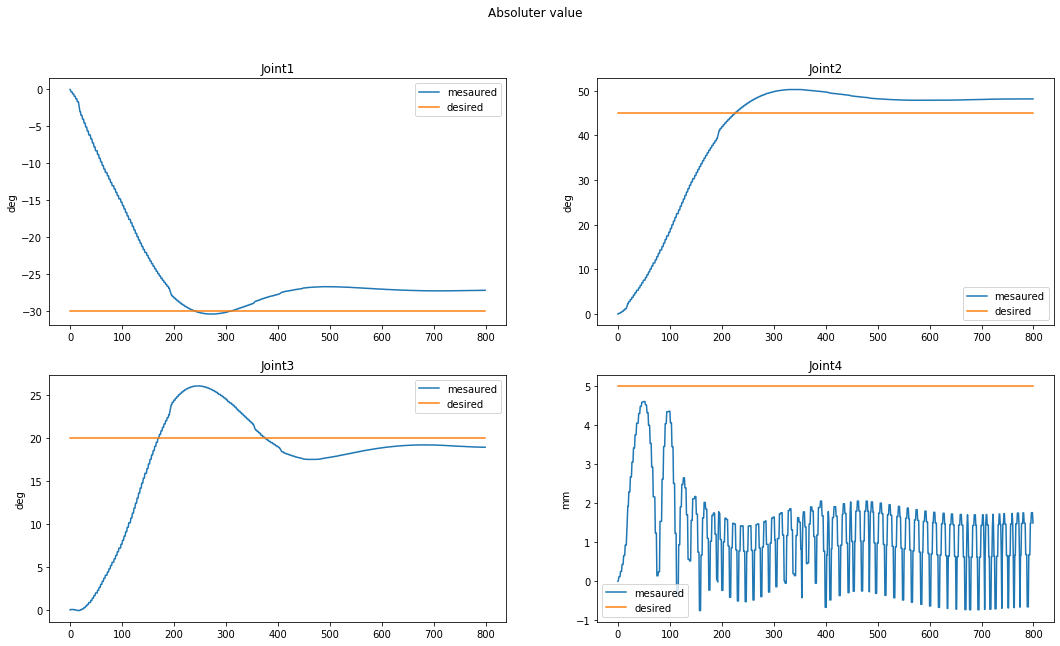

In [54]:
# Plot error of position from joint to joint
plt.figure(figsize=(18,10))
plt.suptitle('Absoluter value')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(mespos[:, i], label='mesaured')
    plt.plot(depos[:, i], label='desired')
    plt.legend()
    if i in [0,1,2]:
        plt.ylabel('deg')
    else:
        plt.ylabel('mm')


In [55]:
tau

array([-0.06038162, -0.01362244,  0.00957028,  0.00162107])

In [50]:
pr.stop()

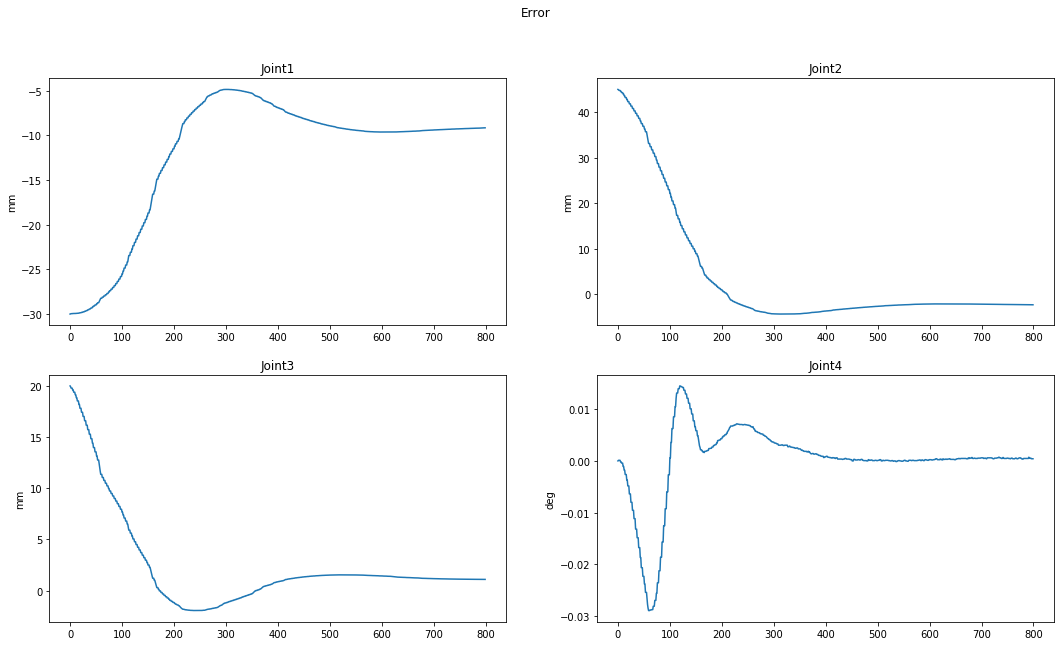

In [23]:
# Plot error of position from joint to joint
plt.figure(figsize=(18,10))
plt.suptitle('Error')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(np.array(err_pos)[:, i])
    if i in [0,1,2]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')

In [ ]:
pr.shutdown()